In [4]:
from ptracking.topic import topics

petition_topics, _ = topics()
petition_topics

,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9
petition_id,,,,,,,,,,
89,0.002790,0.002790,0.002790,0.002790,0.002790,0.002790,0.002790,0.002790,0.002790,0.974891
337,0.006294,0.651106,0.006293,0.298540,0.006295,0.006294,0.006294,0.006295,0.006295,0.006295
540,0.004177,0.004178,0.004177,0.004177,0.004177,0.004177,0.004177,0.962403,0.004177,0.004177
572,0.003047,0.003046,0.003047,0.003047,0.003046,0.003047,0.003046,0.003047,0.972581,0.003047
457,0.969738,0.003362,0.003362,0.003362,0.003362,0.003362,0.003363,0.003363,0.003362,0.003362
...,...,...,...,...,...,...,...,...,...,...
598322,0.002864,0.002864,0.002864,0.002864,0.701829,0.002864,0.002864,0.275259,0.002864,0.002864
598526,0.004570,0.004570,0.004570,0.004570,0.004570,0.958872,0.004570,0.004570,0.004570,0.004570
598605,0.778971,0.002195,0.002195,0.002195,0.002195,0.002195,0.203468,0.002195,0.002195,0.002195


In [5]:
from ptracking.predict import Dataset

dataset = Dataset().prepare(columns=["created_at"]).join(petition_topics)
dataset.sort_values("created_at", inplace=True)

dataset

,signatures,created_at,class,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9
petition_id,,,,,,,,,,,,,
89,1174,2011-08-02 07:54:43.000,4,0.002790,0.002790,0.002790,0.002790,0.002790,0.002790,0.002790,0.002790,0.002790,0.974891
337,262,2011-08-02 07:55:08.000,3,0.006294,0.651106,0.006293,0.298540,0.006295,0.006294,0.006294,0.006295,0.006295,0.006295
540,887,2011-08-02 07:55:33.000,3,0.004177,0.004178,0.004177,0.004177,0.004177,0.004177,0.004177,0.962403,0.004177,0.004177
572,60,2011-08-02 07:57:25.000,2,0.003047,0.003046,0.003047,0.003047,0.003046,0.003047,0.003046,0.003047,0.972581,0.003047
457,72,2011-08-02 07:59:52.000,2,0.969738,0.003362,0.003362,0.003362,0.003362,0.003362,0.003363,0.003363,0.003362,0.003362
...,...,...,...,...,...,...,...,...,...,...,...,...,...
598322,45,2021-10-11 14:25:35.109,2,0.002864,0.002864,0.002864,0.002864,0.701829,0.002864,0.002864,0.275259,0.002864,0.002864
598526,20,2021-10-11 14:27:36.142,2,0.004570,0.004570,0.004570,0.004570,0.004570,0.958872,0.004570,0.004570,0.004570,0.004570
598605,1590,2021-10-11 14:31:24.991,4,0.778971,0.002195,0.002195,0.002195,0.002195,0.002195,0.203468,0.002195,0.002195,0.002195


In [6]:
from sklearn.model_selection import TimeSeriesSplit
from ptracking.predict import BaselinePredictor, Evaluator

k = 5
lookup = dataset['signatures'].to_dict()
baseline = BaselinePredictor(lookup, k=5)

topic_vects = petition_topics.to_numpy()
petition_ids = petition_topics.index.to_numpy()
labels = dataset['signatures'].to_numpy()

tscv = TimeSeriesSplit(n_splits=len(topic_vects) - k, test_size=1)
evaluator = Evaluator(tscv)

# We have to use petition_ids as the label because baseline predictor
# uses them as a way to retrieve signatures (and other features) of
# petitions. Normally, we use the signature count for the label
results = evaluator.run_model(baseline, topic_vects, petition_ids)

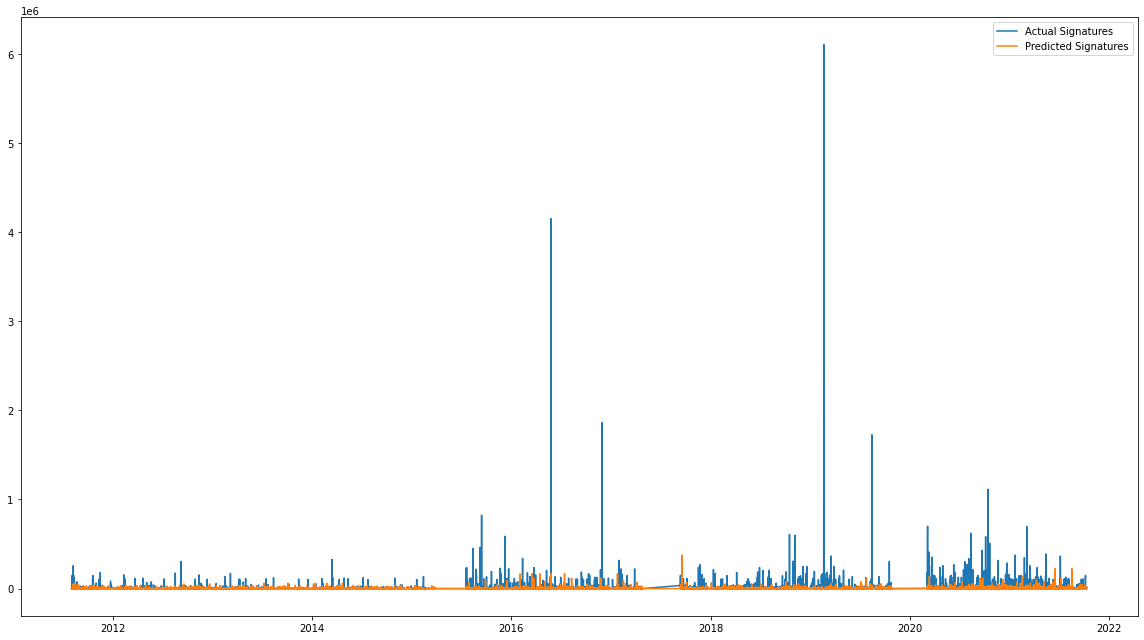

In [7]:
from ptracking.predict import Plotter

plotter = Plotter(petition_ids_index=dataset.index)
plotter.plot_results(results.flatten(), labels, list(dataset.created_at))

In [8]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=5)

results = evaluator.run_model(knn, topic_vects, dataset['class'].to_numpy())

38.57021853294935


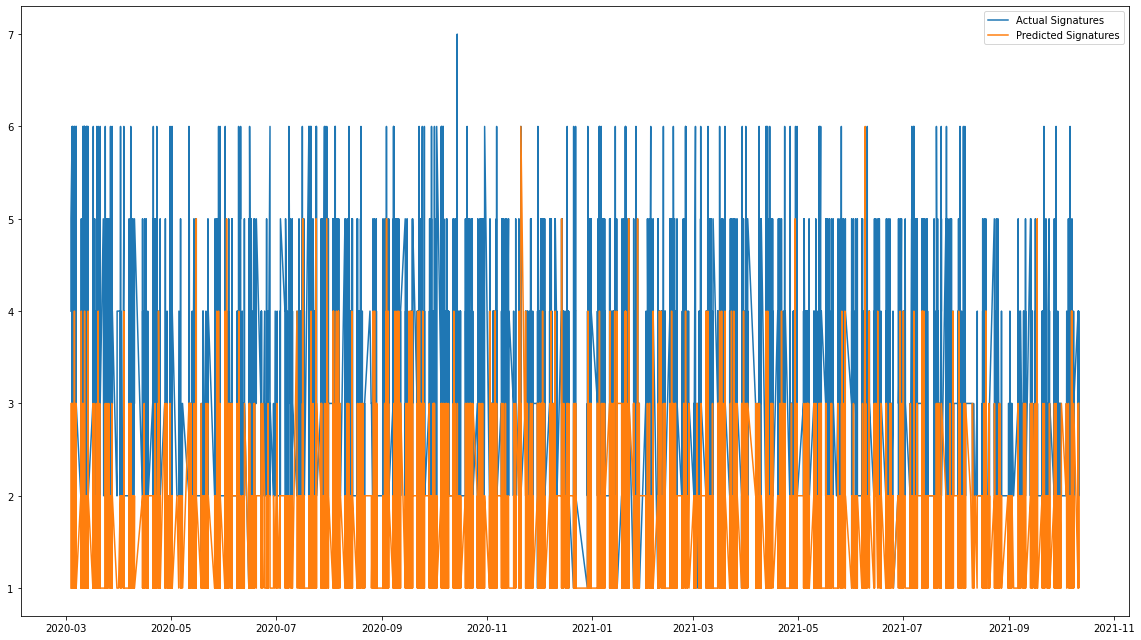

In [9]:
import numpy as np

# Accuracy in terms of how many times we get it right
print(
    sum(
        int(x)
        for x in np.equal(results.flatten(), dataset['class'].to_numpy())) /
    len(dataset) * 100)

plotter.plot_results(results.flatten(),
                     dataset['class'],
                     dataset['created_at'],
                     filter_after="2020-01-01")
